<a href="https://colab.research.google.com/github/romenlaw/ML-playground/blob/main/ml_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro
* **AI**
 * **Machine Learning** (ML) - the set of all tasks in which a computer can make decisions *based on data*.
   * **Deep Learning** (DL) - ML using neuro-net

**Reinforcement Learning (RL)** - ML in which no data is given, agent learns to perform task by interacting with env.

## Definitions:
* **Model** - rules on data and used to make predictions
* **Algorithm** - used to build the model
* **Feature** - data properties/characteristics that model uses for prediction
* **Label** - target feature of the prediction.
* **Predictions** - output of the model.
* **weights** - in the model formula, each feature is multiplied wby a corresponding factor (weight)
* **bias** - in the model formula, constant that is not attached to any features.
* **hyperparameters** - any quantity set before the training; e.g. learning rate, number of epochs, degree (of polynomial regression) etc.
* **parameter** - any quantity that the model creates/updates during training process

## Types of models and algorithms:
* **Supervised learning** - ML that works with labeled data. Supervised learning models:
  * **regression model** - predicts numerical data (outputs number)
  * **classification model** - predicts category (outputs category)
* **Unsupervised learning** - ML that works with unlabeled data. Unsupervised learning algos:
  * **clustering algos** - group data into clusters based on similarity. e.g.
    * **K-means clustering** - groups points by picking some random centers of mass and move them closer and closer to the points till the are at the right spots
    * **Hierarchical clustering** - starts by grouping the closest points together and continueing till we have some well-defined groups
    * **Density-based spatial clustering (DBSCAN)** - starts grouping points in places with high density, while labeling the isolated points as noise.
    * **Gaussian mixtrue models** - assignes fractions of the point to each of the existing clusters.
  * **dimentionality reduction** algos - similify data and faithfully describe it with fewer features
  * combination of clustering and dimensionality reduction. They express big matrix of data into product of smaller matrices
    * **Matrix factorization** - e.g. movie recommendation
    * **Single value decomposition** - uses linear algebra, e.g. image compression
  * **generative algos** - generate new data points that resemble the existing data
    * **Generative adversarial networks (GANs)**
    * **Variational autoencoders (VAEs)**
    * **Restricted Boltzmann machines (RBMs)**






In [2]:
!rm -f data/*
!wget -nv -P data https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_03_Linear_Regression/Hyderabad.csv
!ls -al data
!wc -l data/Hyderabad.csv

2025-02-18 10:17:21 URL:https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_03_Linear_Regression/Hyderabad.csv [253067/253067] -> "data/Hyderabad.csv" [1]
total 256
drwxr-xr-x 2 root root   4096 Feb 18 10:17 .
drwxr-xr-x 1 root root   4096 Feb 18 10:17 ..
-rw-r--r-- 1 root root 253067 Feb 18 10:17 Hyderabad.csv
2518 data/Hyderabad.csv


In [3]:
import random
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd

def draw_line(slope, y_intercept, color='grey', linewidth=0.7, starting=0, ending=8):
    x = np.linspace(starting, ending, 1000)
    plt.plot(x, y_intercept + slope*x, linestyle='-', color=color, linewidth=linewidth)

def plot_points(features, labels):
    X = np.array(features)
    y = np.array(labels)
    plt.scatter(X, y)
    plt.xlabel('number of rooms')
    plt.ylabel('prices')

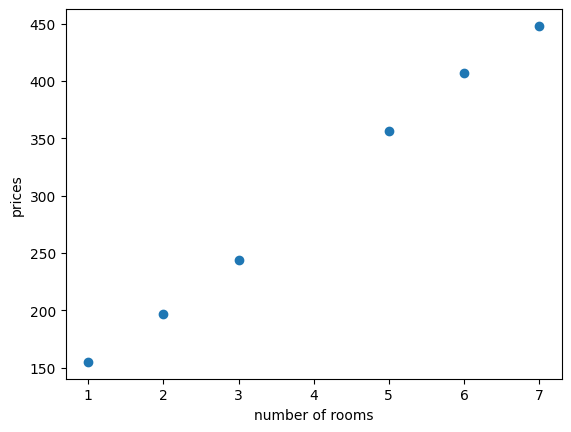

In [4]:
# load the data and plot them
features = np.array([1,2,3,5,6,7])
labels = np.array([155, 197, 244, 356, 407, 448])
plot_points(features, labels)

# Linear Regression
Drawing a line close to the data points. Start with random values for slope and y-intercept, rotate/move line based on formulae many times till it fits the points well. Each interation is called an **epoch**.

In the house price example:
* $p$: the price of a house in the dataset
* $\hat p$: the predicted price of a house
* $r$: number of rooms
* $m$: price per room
* $b$: base price of a house (bias?)

The linear regression model to predict house price: $\hat p=mr + b$

In [5]:
# simple trick
def simple_trick(base_price, price_per_room, num_rooms, price, learning_rate=0.1):
    small_random_1 = random.random()*learning_rate
    small_random_2 = random.random()*learning_rate
    predicted_price = base_price + price_per_room*num_rooms
    if price > predicted_price and num_rooms > 0:
        price_per_room += small_random_1
        base_price += small_random_2
    if price > predicted_price and num_rooms < 0:
        price_per_room -= small_random_1
        base_price += small_random_2
    if price < predicted_price and num_rooms > 0:
        price_per_room -= small_random_1
        base_price -= small_random_2
    if price < predicted_price and num_rooms < 0:
        price_per_room -= small_random_1
        base_price += small_random_2
    return price_per_room, base_price

# square trick - we use p-p_hat and r to reduce 4 cases into 1.
def square_trick(base_price, price_per_room, num_rooms, price, learning_rate):
  # print("in square_trick:", base_price, price_per_room, num_rooms, price, learning_rate)
  # p_hat = b + mr
  predicted_price = base_price + price_per_room * num_rooms
  # add lr*(p-p_hat) to b and obtain new b'
  base_price += learning_rate * (price - predicted_price)
  # add lr*r*(p-p_hat) to slope to get new m'. The r is used here because it provides
  # the sign (+/-). So the r(p-p_hat) always gives the right sign.
  price_per_room += learning_rate * num_rooms * (price-predicted_price)

  return price_per_room, base_price

# absolute trick - it's an intermediate between simple and square tricks
# here we only use r to reduce 4 cases into 2.
def absolute_trick(base_price, price_per_room, num_rooms, price, learning_rate):
  # p_hat = b + mr
  predicted_price = base_price + price_per_room * num_rooms
  if price > predicted_price: # p is above the line
    price_per_room += learning_rate * num_rooms # rotate line anti-clockwise
    base_price += learning_rate # move line up
  else: # p is below the line
    price_per_room -= learning_rate * num_rooms # rotate line clockwise
    base_price -= learning_rate # move line down

  return price_per_room, base_price


base price=99.57793333465827, price per room=49.911321045383566


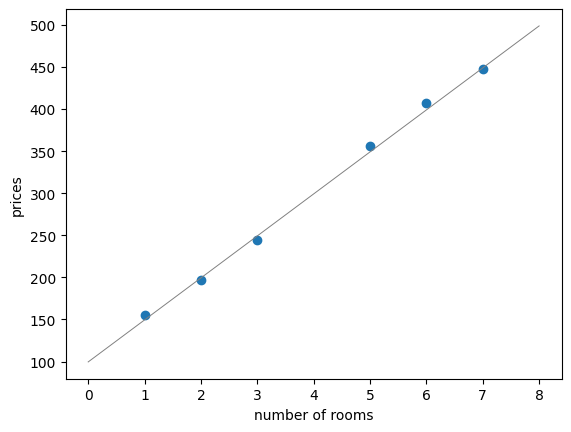

In [6]:
# linear regression algo using square trick
def linear_regression(features,  #1-D array of numbers of rooms
                      labels,   # 1-D array of house prices
                      learning_rate=0.01, epochs=1000,
                      error_fn=square_trick):
  ms, bs = [0.0] * epochs, [0.0] * epochs
  price_per_room = random.random() # float
  base_price = random.random()
  for epoch in range(epochs):
    i = random.randint(0, len(features)-1) # random index of dataset
    num_rooms = features[i]
    price = labels[i]

    # price_per_room, base_price = square_trick(base_price, price_per_room,
    #                                           num_rooms, price, learning_rate)
    price_per_room, base_price = error_fn(base_price, price_per_room, \
                                              num_rooms, price, learning_rate)
    ms[epoch] = price_per_room
    bs[epoch] = base_price

  return ms, bs # price_per_room, base_price
# apply the linear regression on the data
epochs = 10000
lr = 0.01 # a big learning rate will make the model explode
error_fn = square_trick
ms, bs = linear_regression(features, labels, learning_rate=lr, epochs=epochs,
                           error_fn=error_fn)
m, b = ms[-1], bs[-1]
print(f"base price={b}, price per room={m}")
plot_points(features, labels)
draw_line(m, b)

In [7]:
# linspace is no good because the 1st 50 epochs are where most changes happen
TOTAL_FRAMES=50
frames = np.linspace(0, epochs, TOTAL_FRAMES, dtype=np.uint32)
frames, len(frames)

(array([    0,   204,   408,   612,   816,  1020,  1224,  1428,  1632,
         1836,  2040,  2244,  2448,  2653,  2857,  3061,  3265,  3469,
         3673,  3877,  4081,  4285,  4489,  4693,  4897,  5102,  5306,
         5510,  5714,  5918,  6122,  6326,  6530,  6734,  6938,  7142,
         7346,  7551,  7755,  7959,  8163,  8367,  8571,  8775,  8979,
         9183,  9387,  9591,  9795, 10000], dtype=uint32),
 50)

In [8]:
# so I use logspace instead to show more epochs at the beginning
# I also want to show epoch 0, so hardcode it into the frames[]
TOTAL_FRAMES=50
frames = np.logspace(0, np.log10(epochs), TOTAL_FRAMES, dtype=np.uint32)
frames[:2] = 0
frames, len(frames)

(array([    0,     0,     1,     1,     2,     2,     3,     3,     4,
            5,     6,     7,     9,    11,    13,    16,    20,    24,
           29,    35,    42,    51,    62,    75,    91,   109,   132,
          159,   193,   232,   281,   339,   409,   494,   596,   719,
          868,  1048,  1264,  1526,  1842,  2222,  2682,  3237,  3906,
         4714,  5689,  6866,  8286, 10000], dtype=uint32),
 50)

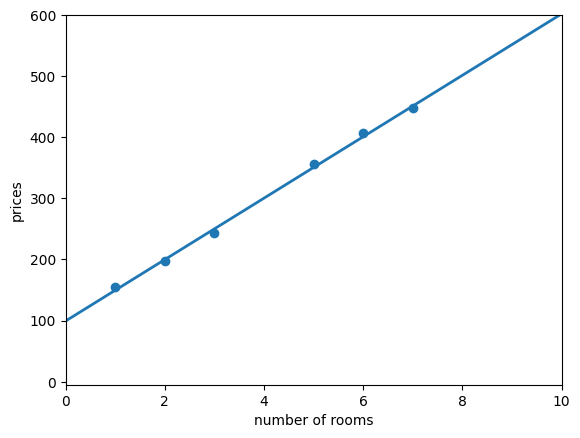

In [10]:
# check the progress of the training
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots()
ax.set_xlim(0, 10)
ax.set_ylim(-5, 600)
ax.scatter(features, labels)
ax.set_xlabel('number of rooms')
ax.set_ylabel('prices')
# ax.set_xlim(0, 2 * np.pi)
# ax.set_ylim(-1, 1)
line, = ax.plot([], [], lw=2)

def init():
  line.set_data([], [])
  return line,

def update(frame):
  # idx = min(epochs-1, (frame+1)*frame_step_size) # linear scale
  idx = min(epochs-1, frames[frame])
  # print(f"frame={frame}, index={idx}")
  x = np.linspace(0, 10, 1000)
  y = ms[idx] * x + bs[idx]
  line.set_data(x, y)
  return line,

ani = FuncAnimation(fig, update, frames=TOTAL_FRAMES, init_func=init, blit=True)
HTML(ani.to_jshtml())

# Error Function
the Error/Cost/Loss function is a metric to tell how the model is doing.
* absolute error - sum of all vertical distances from the line to the points in dataset
* square error - sum of squares of these distances

Square error is used more commonly because it has much nicer derivative tha absolute value.

In practice, the *mean absolute error* (MAE) and *mean square error* (MSE) are much more commonly used. The mean (average) takes care of large datasets (otherwise, they would appear to have much bigger error than smaller dataset, since we only add the errors up).

*Root mean square error* (RMSE) take square root on MSE, this takes care of the unit of the error (matching the predictions unit, such as $).

base price=99.46258480311951, price per room=49.79624054055591


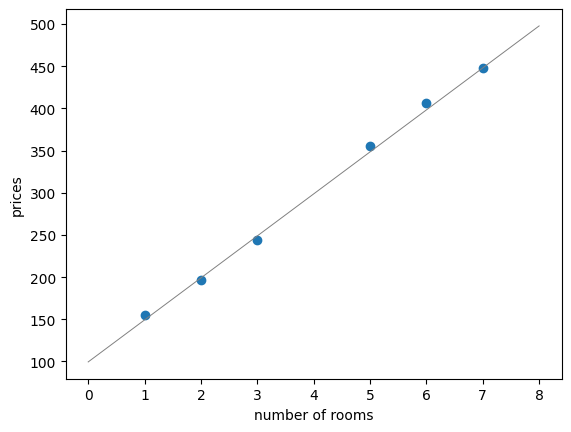

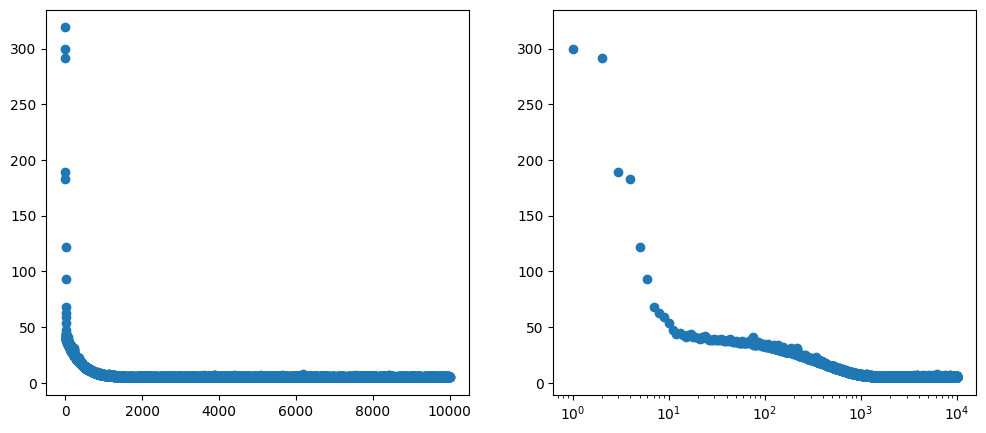

In [39]:
def rmse(labels, predictions): # they are both lists of scalars
  n = len(labels)
  diffs = np.subtract(labels, predictions)
  return np.sqrt(1.0 / n * (np.dot(diffs, diffs)))

# linear regression algo using square trick
def linear_regression(features,  #1-D array of numbers of rooms
                      labels,   # 1-D array of house prices
                      learning_rate=0.01, epochs=1000,
                      error_fn=square_trick):
  ms, bs, errs = [0.0] * epochs, [0.0] * epochs, [0.0] * epochs
  price_per_room = random.random() # float
  base_price = random.random()
  for epoch in range(epochs):
    i = random.randint(0, len(features)-1) # random index of dataset
    num_rooms = features[i]
    price = labels[i]
    predictions = features * price_per_room + base_price
    errs[epoch] = rmse(labels, predictions)
    # price_per_room, base_price = square_trick(base_price, price_per_room,
    #                                           num_rooms, price, learning_rate)
    price_per_room, base_price = error_fn(base_price, price_per_room, \
                                              num_rooms, price, learning_rate)
    ms[epoch] = price_per_room
    bs[epoch] = base_price

  return ms, bs, errs # price_per_room, base_price

epochs = 10000
lr = 0.01 # a big learning rate will make the model explode
error_fn = square_trick
ms, bs, errs = linear_regression(features, labels, learning_rate=lr, epochs=epochs,
                           error_fn=error_fn)
m, b = ms[-1], bs[-1]
print(f"base price={b}, price per room={m}")
plot_points(features, labels)
draw_line(m, b)
plt.show()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax2.set_xscale('log')
# ax2.set_yscale('log')
ax2.scatter(range(len(errs)), errs)
ax1.scatter(range(len(errs)), errs)
plt.show()

By looking at the above error plot, we only need to train the model for 1000-2000 epochs.

# Stochastic and Batch Gradient Descent
Notice that the error can be calculated on the entire dataset or on just one point, but both may be expensive to do. So a middle ground is *mini-batch learning*:
* divide data into many mini-batches
* pick one of the mini-batches and do the training (adjust weights to reduce error in mini-batch)

3 general types of gradient descent algos:
1. using one point at a time - it's *stochastic gradient descent*
2. using mini-batch - it's called *mini-batch gradient descent*.
3. using entire dataset - it's called *batch gradient descent*.

# Example - House Pricing

In [9]:
data = pd.read_csv('data/Hyderabad.csv')

In [105]:
data.head()

,Price,Area,Location,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,...,LiftAvailable,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator
0,6968000,1340,Nizampet,2,0,0,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
1,29000000,3498,Hitech City,4,0,0,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
2,6590000,1318,Manikonda,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5739000,1295,Alwal,3,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,5679000,1145,Kukatpally,2,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


In [106]:
data.describe()

,Price,Area,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,RainWaterHarvesting,...,LiftAvailable,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator
count,2.518000e+03,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,...,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000
mean,9.818380e+06,1644.571088,2.623511,0.227562,0.412629,0.739873,0.709690,0.619142,0.559968,0.606434,...,0.975774,0.360207,0.607228,0.342732,0.330024,0.321287,0.334392,0.342335,0.341144,0.324861
std,8.777113e+06,746.256956,0.687330,0.419341,1.626445,1.611024,1.615231,1.624426,1.627686,1.625308,...,1.557725,1.622778,1.625256,1.621178,1.619894,1.618953,1.620347,1.621139,1.621023,1.619344
min,2.000000e+06,500.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.760000e+06,1160.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.754000e+06,1500.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.090000e+07,1829.000000,3.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.650000e+08,9400.000000,8.000000,1.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,...,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000


base price=-2.0971958687308243, price per room=6576.139596777587


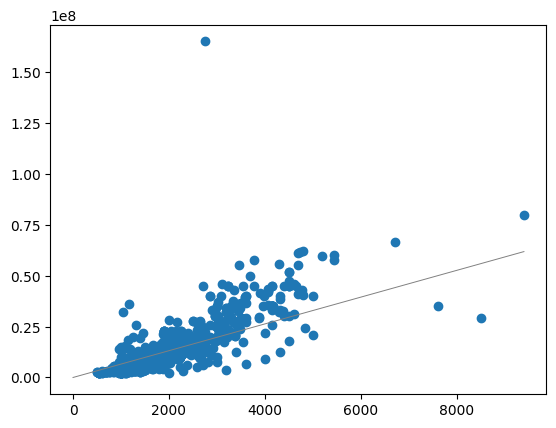

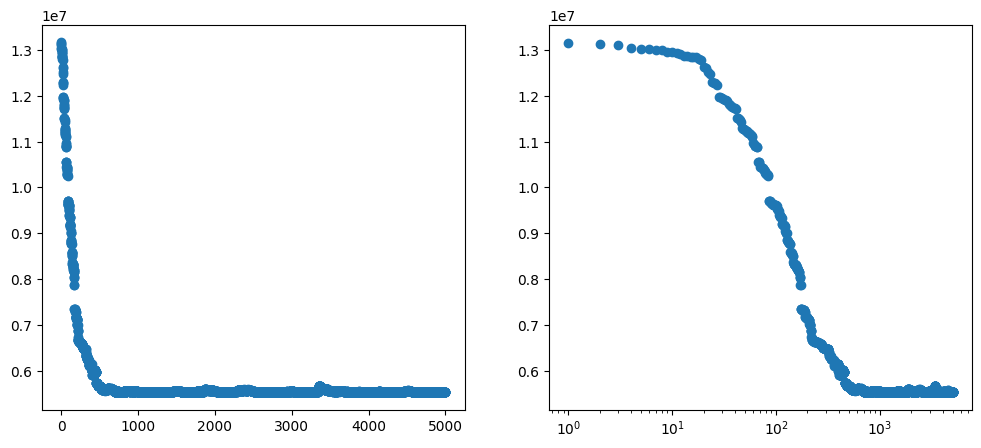

In [40]:
epochs = 5000
lr = 1e-9 # a big learning rate will make the model explode
error_fn = square_trick
x = data["Area"].values
y = data["Price"].values
ms, bs, errs = linear_regression(x, y, learning_rate=lr, epochs=epochs,
                           error_fn=error_fn)
m, b = ms[-1], bs[-1]
print(f"base price={b}, price per room={m}")
plt.scatter(x, y)
draw_line(m, b,starting=0, ending=max(x))
plt.show()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax2.set_xscale('log')
# ax2.set_yscale('log')
ax2.scatter(range(len(errs)), errs)
ax1.scatter(range(len(errs)), errs)
plt.show()

In [42]:
x=data[["Area", "No. of Bedrooms"]].values
x

array([[1340,    2],
       [3498,    4],
       [1318,    2],
       ...,
       [2625,    3],
       [2050,    3],
       [1805,    3]])

In [36]:
x = data["Area"].values
x = np.expand_dims(x, axis=1)
x.shape, x

((2518, 1),
 array([[1340],
        [3498],
        [1318],
        ...,
        [2625],
        [2050],
        [1805]]))

# Generic Linear Regression
The general case will consists of a dataset of $m$ points and $n$ features.
* data points are $x^{(1)}, x^{(2)}, \ldots, x^{(m)}$. Each point is a vector $x^{(i)}=\left(x_1^{i}, x_2^{i}, \ldots, x_n^{i} \right)$
* the corresponding labels are $y_1, y_2, \ldots, y_m$
* weights of the model are $w_1, w_2, \ldots, w_n$
* bias is $b$

Vectorised version of the above functions.

m, n= 2518 2
base price=-1.5704256279612865, price per ...=6379.3381451426


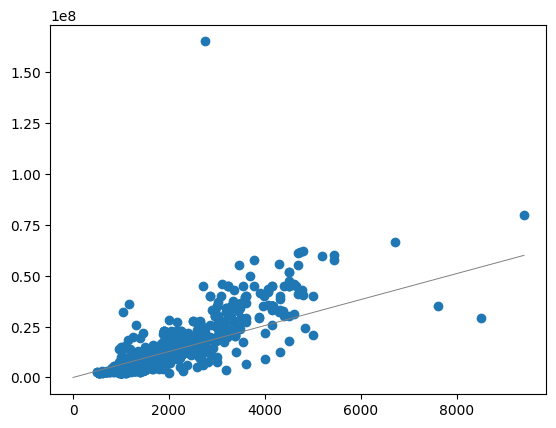

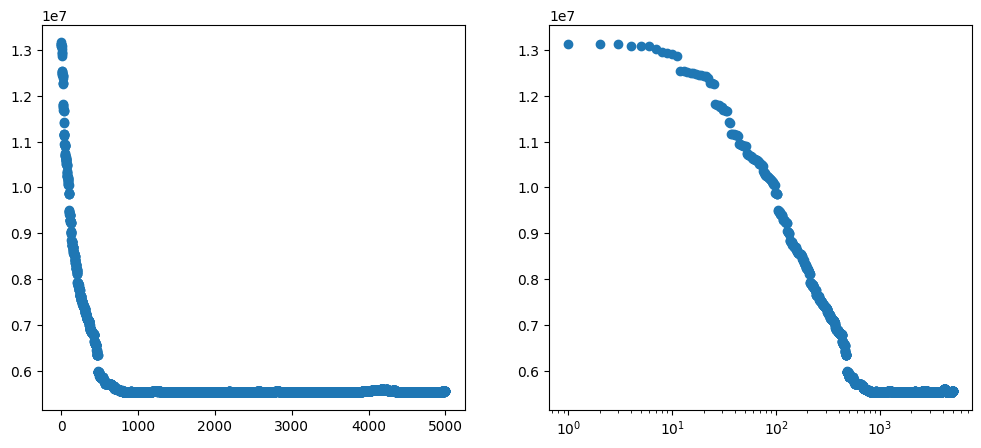

In [74]:
def general_square_trick(b, # scalar
                         w, # weights dim: (n)
                         x, # features dim: (n)
                         y, # labels dim: scalar
                         lr):
  y_hat = w.dot(x) + b

  delta = (y - y_hat) * lr # scalar

  b += delta
  w = w + x * delta # (n)

  return w, b

def rmse(labels, predictions):
    # n = labels.shape[0]
    # differences = np.subtract(labels, predictions)
    # return np.sqrt(1.0/n * (np.dot(differences, differences)))
    return np.sqrt(np.mean((predictions - labels) ** 2))

# linear regression algo using square trick
def general_linear_regression(X, # (m,n) a batch of x
                              Y, # (m) a batch of y
                              lr=0.01, epochs=1000):
  ws, bs, errs = [], [], []
  m, n=X.shape
  w = np.random.rand(n)
  b = random.random()

  print("m, n=", m, n)

  for epoch in range(epochs):
    Y_hat = X.dot(w) + b
    np_rmse = rmse(Y, Y_hat)
    errs.append(np_rmse)

    i = random.randint(0, m-1) # random index of dataset
    x = X[i]
    y = Y[i]

    w, b = general_square_trick(b, w, x, y, lr)
    ws.append(w)
    bs.append(b)
  return ws, bs, errs # price_per_room, base_price

epochs = 5000
lr = 1e-9 # a big learning rate will make the model explode
X = data[["Area", "No. of Bedrooms"]].values
# X = np.expand_dims(data["Area"].values, axis=1)
Y = data["Price"].values
ms, bs, errs = general_linear_regression(X, Y, lr=lr, epochs=epochs)

feature_idx=0 # 0=area, 1=no. bedrooms

m, b = ms[-1][feature_idx], bs[-1]
print(f"base price={b}, price per ...={m}")
plt.scatter(X[:,feature_idx], Y)
draw_line(m, b,starting=0, ending=max(X[:,feature_idx]))
plt.show()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax2.set_xscale('log')
# ax2.set_yscale('log')
ax2.scatter(range(len(errs)), errs)
ax1.scatter(range(len(errs)), errs)
plt.show()

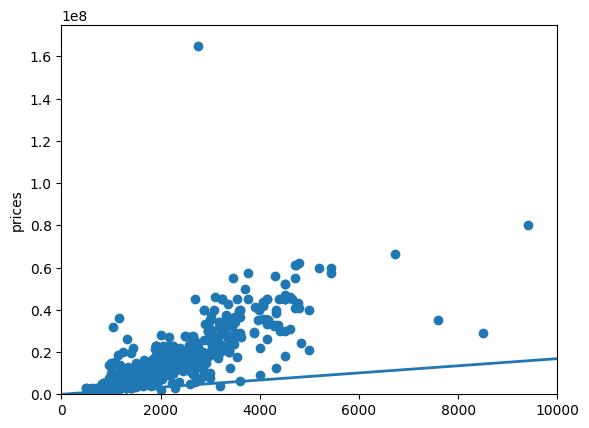

In [78]:
# check the progress of the training
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots()
ax.set_xlim(0, 10000)
ax.set_ylim(-5, 1.75e8)
ax.scatter(x[:,feature_idx], y)
# ax.set_xlabel('number of rooms')
ax.set_ylabel('prices')
line, = ax.plot([], [], lw=2)

def init():
  line.set_data([], [])
  return line,

def update(frame):
  # idx = min(epochs-1, (frame+1)*frame_step_size) # linear scale
  idx = min(epochs-1, frames[frame])
  # print(f"frame={frame}, index={idx}")
  x = np.linspace(0, 10000, 1000)
  y = ms[idx][feature_idx] * x + bs[idx]
  line.set_data(x, y)
  return line,

ani = FuncAnimation(fig, update, frames=TOTAL_FRAMES, init_func=init, blit=True)
HTML(ani.to_jshtml())

# Polynomial Regression
to model non-linear data.